# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
%matplotlib inline

## Read in an Image

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

# Utility for a batch of test images
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
# Experiments show that HLS is the best color space to specify both yellow color and white color
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

# An image is expected be in RGB color space
def select_rgb_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=15):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# region of interest
def roi(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    # first, define the polygon by vertices
    rows, cols = img.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(image, lines, color=[255, 0, 0], thickness=10):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    img = np.copy(image) # don't want to modify the original
    for line in lines:
        if line is not None:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img

def hough_lines(img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    return cv2.HoughLinesP(img, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# derive left/right lane lines from list of lines reached by Hough transform
def lane_lines(image, lines):

    ybtm = image.shape[0] # define the y bottom value
    ytop = ybtm * 0.6 # define the top y value, some portion of y bottom value
    left_line = []
    right_line = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1 == x2:  # ignore vertical lines
                continue
            slope = (y2 - y1)/(x2 - x1)
            # obtain points on left line
            if slope < -0.3 and slope > -0.9:
                left_line.append((x1, y1))
                left_line.append((x2, y2))
            # obtain points on right line
            elif slope > 0.3 and slope < 0.9:
                right_line.append((x1, y1))
                right_line.append((x2, y2))
            
    distType = cv2.DIST_L12
    param = 0
    reps = 0.01
    aeps = 0.01
    
    if left_line is not None:
        [left_vx, left_vy, left_px, left_py] = cv2.fitLine(np.array(left_line),
                                    distType, param, reps, aeps)
        left_slope = left_vy / left_vx
        # process left line
        # calculate x top 
        left_xtop = (ytop - left_py) / left_slope + left_px
        # calculate x bottom
        left_xbtm = (ybtm - left_py) / left_slope + left_px
        leftline = np.array([(int)(left_xbtm[0]), ybtm, (int)(left_xtop[0]), (int)(ytop)])

    if left_line is not None:
        [right_vx, right_vy, right_px, right_py] = cv2.fitLine(np.array(right_line),
                                    distType, param, reps, aeps)
        right_slope = right_vy / right_vx
        # process right line
        # calculate x top 
        right_xtop = (ytop - right_py) / right_slope + right_px
        # calculate x bottom
        right_xbtm = (ybtm - right_py) / right_slope + right_px
        rightline = np.array([(int)(right_xbtm[0]), ybtm, (int)(right_xtop[0]), (int)(ytop)])
    return (np.array([[leftline], [rightline]]))

def pipeline(img):
    white_yellow_image = select_rgb_white_yellow(img)
    gray_image = grayscale(white_yellow_image)
    blurred_image = gaussian_blur(gray_image)
    edge_image = canny(blurred_image)
    roi_image = roi(edge_image)
    list_of_lines = hough_lines(roi_image)
    lane_image = draw_lines(img,lane_lines(img,list_of_lines))
    return lane_image

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'YellowUnderShade.jpg',
 'YellowUnderShade2.jpg',
 'YellowWhite.jpg',
 'YellowWhite2.jpg']

### Step 0: read images as RGB

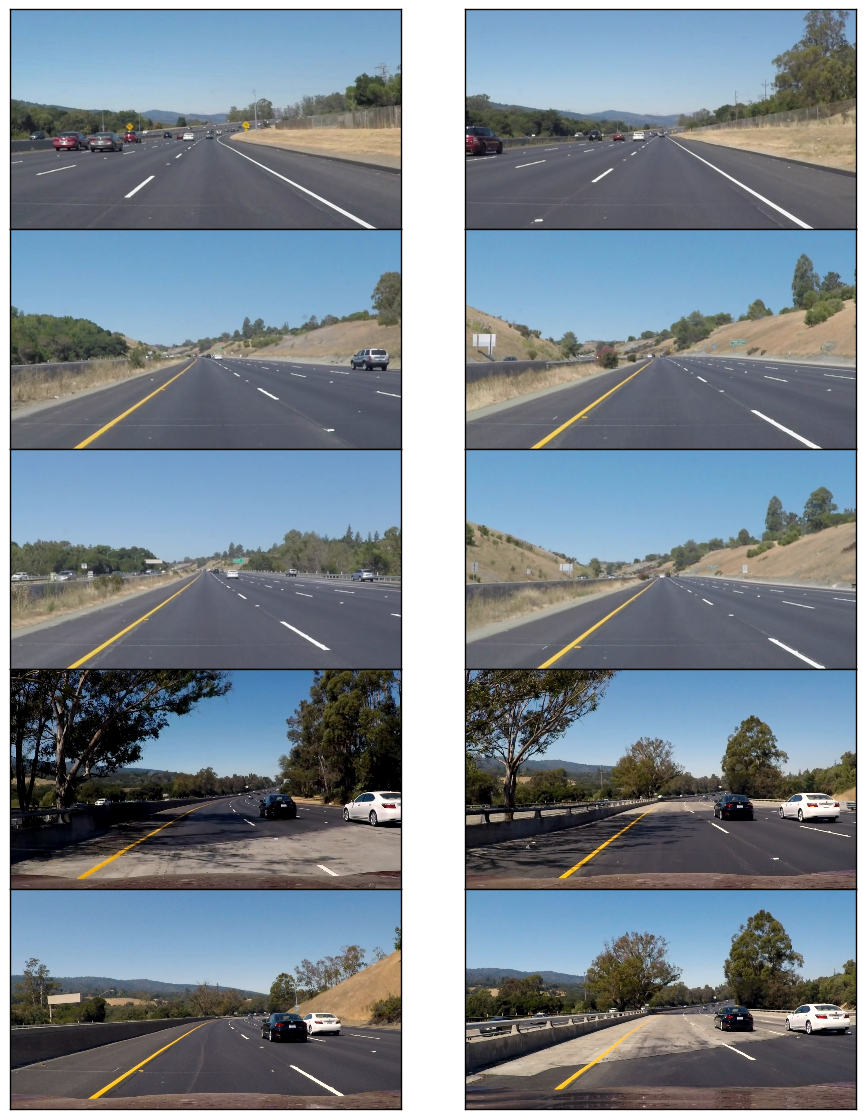

In [4]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]
show_images(test_images)

### Step 1: select rgb white yellow color

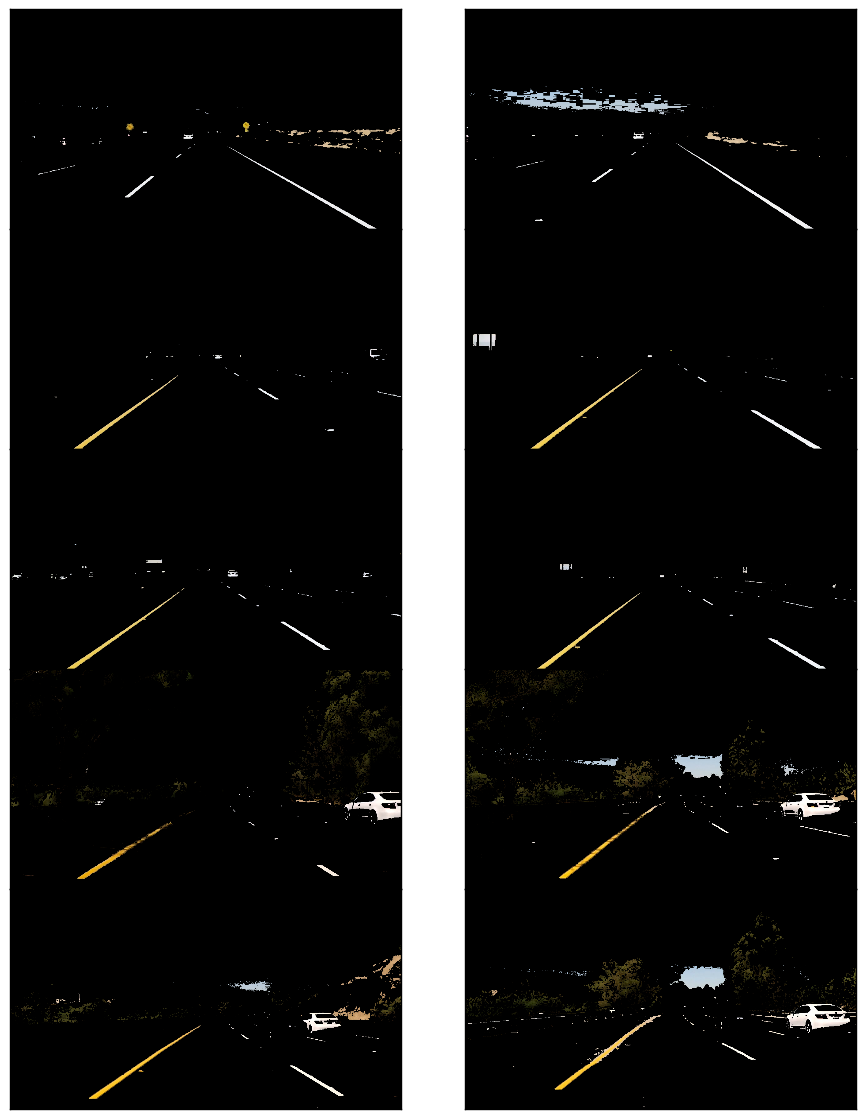

In [5]:
white_yellow_images = list(map(select_rgb_white_yellow, test_images))
show_images(list(map(select_rgb_white_yellow, test_images)))

### Step 2: Convert to gray scale

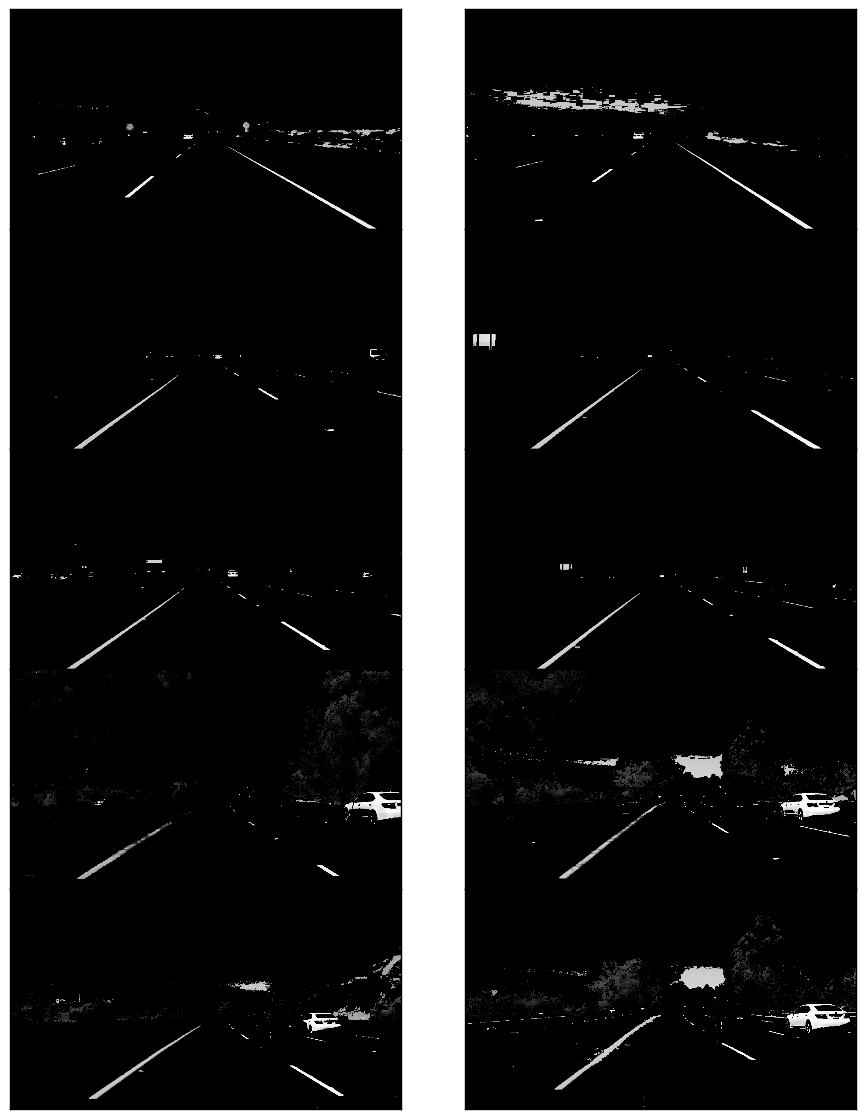

In [6]:
gray_images = list(map(grayscale, white_yellow_images))
show_images(gray_images)

In [43]:
### Step 3: Apply GaussianBlur

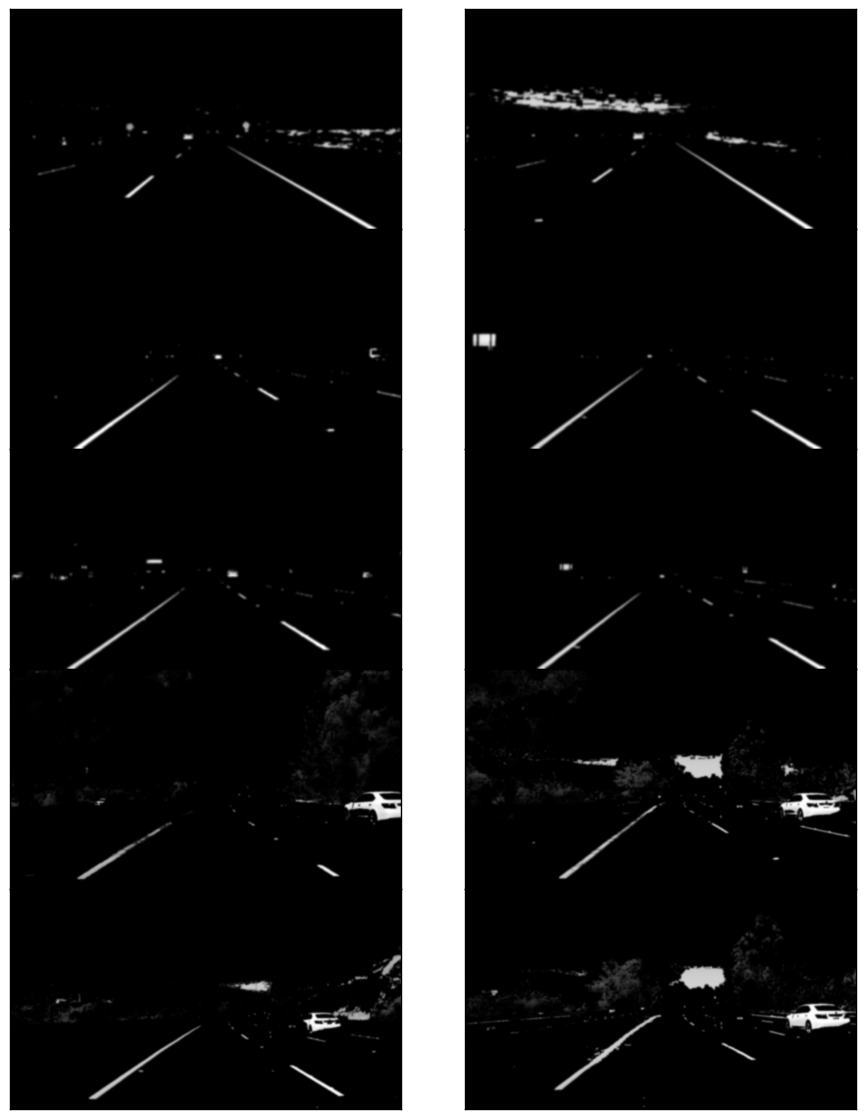

In [7]:
blurred_images = list(map(lambda image: gaussian_blur(image), gray_images))
show_images(blurred_images)

### Step 4: Canny edge detection

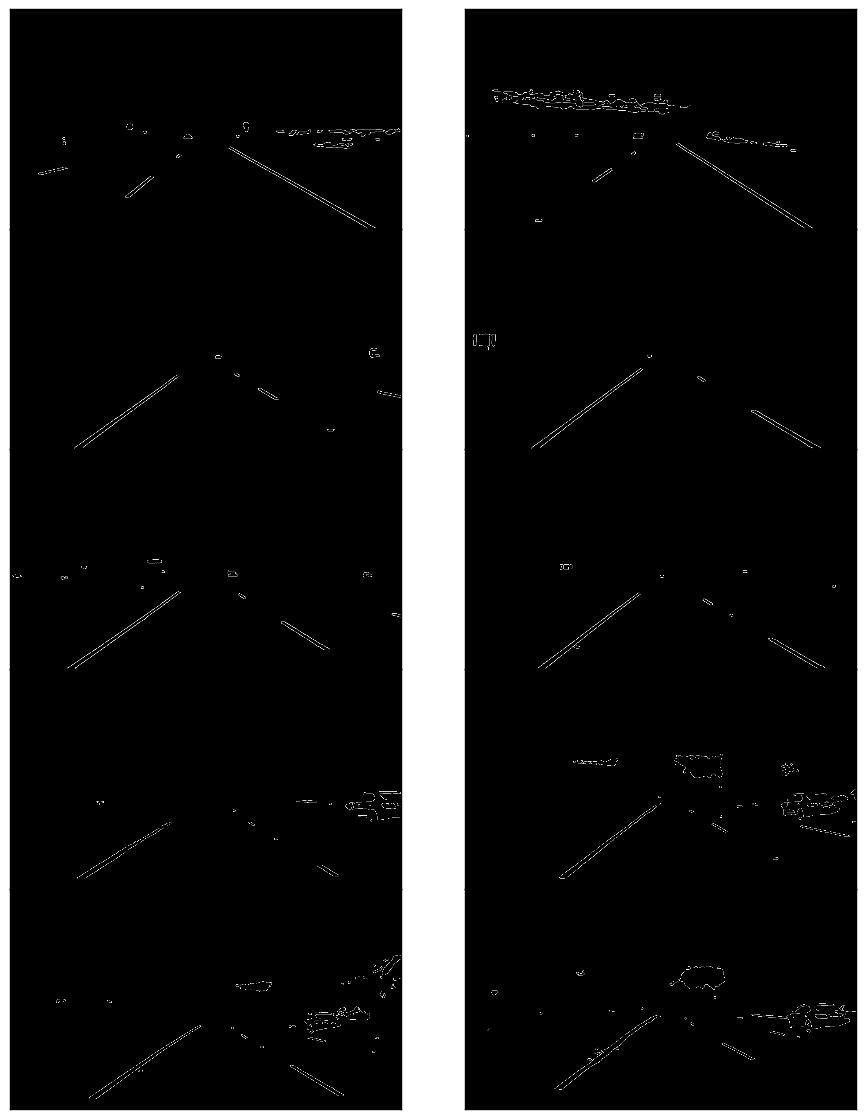

In [8]:
edge_images = list(map(lambda image: canny(image), blurred_images))
show_images(edge_images)

### Step 5: Select ROI (region of Interest)

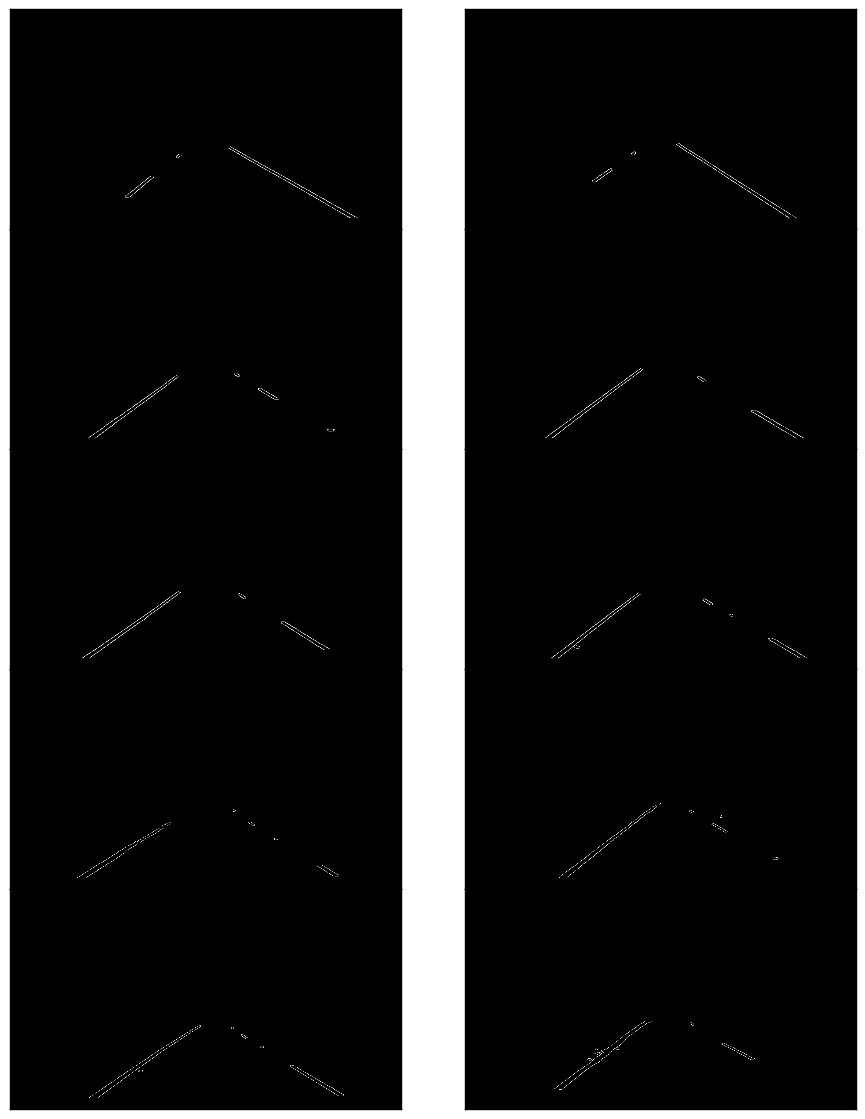

In [9]:
# images showing the region of interest only
roi_images = list(map(roi, edge_images))
show_images(roi_images)

### Step 6: Hough transformation

In [10]:
list_of_lines = list(map(hough_lines, roi_images))

# Step 7: Draw identified lane lines in original images

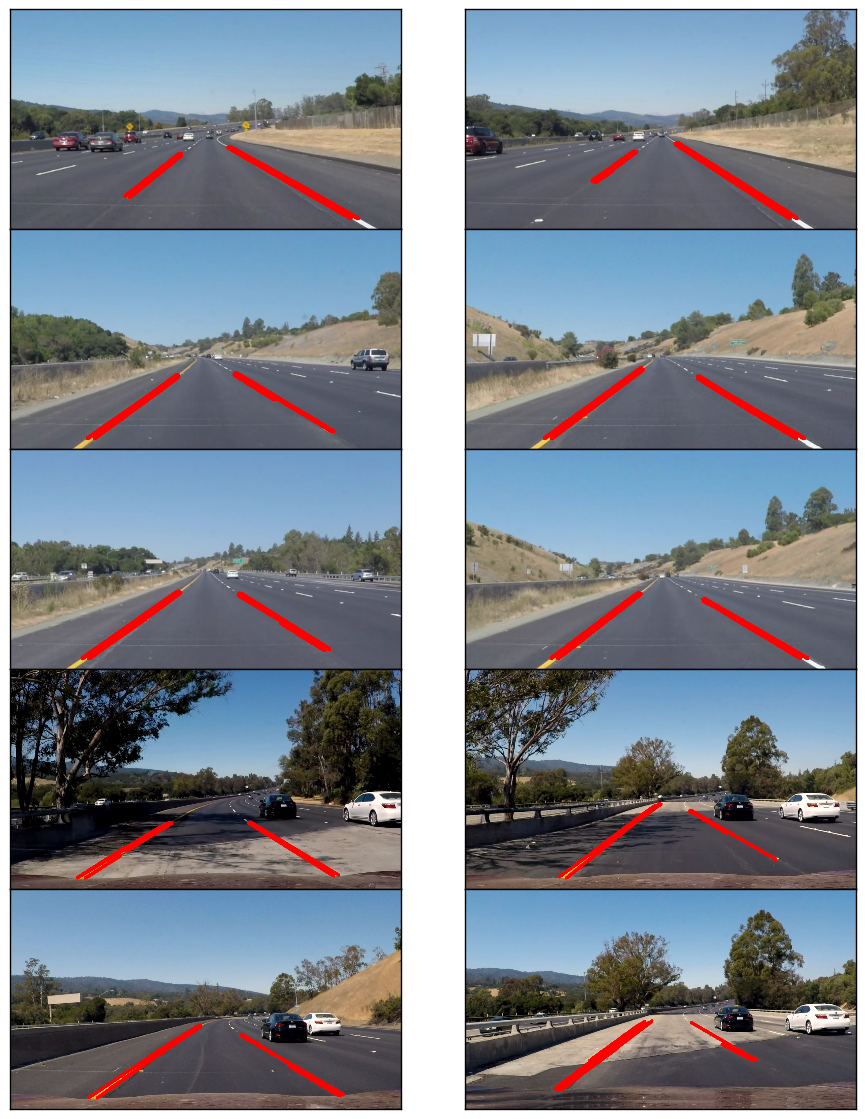

In [11]:
line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

### Step 8: Averaging and Extrapolating Lines
There are multiple lines detected for a lane line. We should come up with an averaged line for that.
Also, some lane lines are only partially recognized. We should extrapolate the line to cover full lane line length.
We want two lane lines: one for the left and the other for the right. The left lane should have a positive slope, and the right lane should have a negative slope. Therefore, we'll collect positive slope lines and negative slope lines separately and take averages.
Note: in the image, y coordinate is reversed. The higher y value is actually lower in the image. Therefore, the slope is negative for the left lane, and the slope is positive for the right lane.
In [15]:


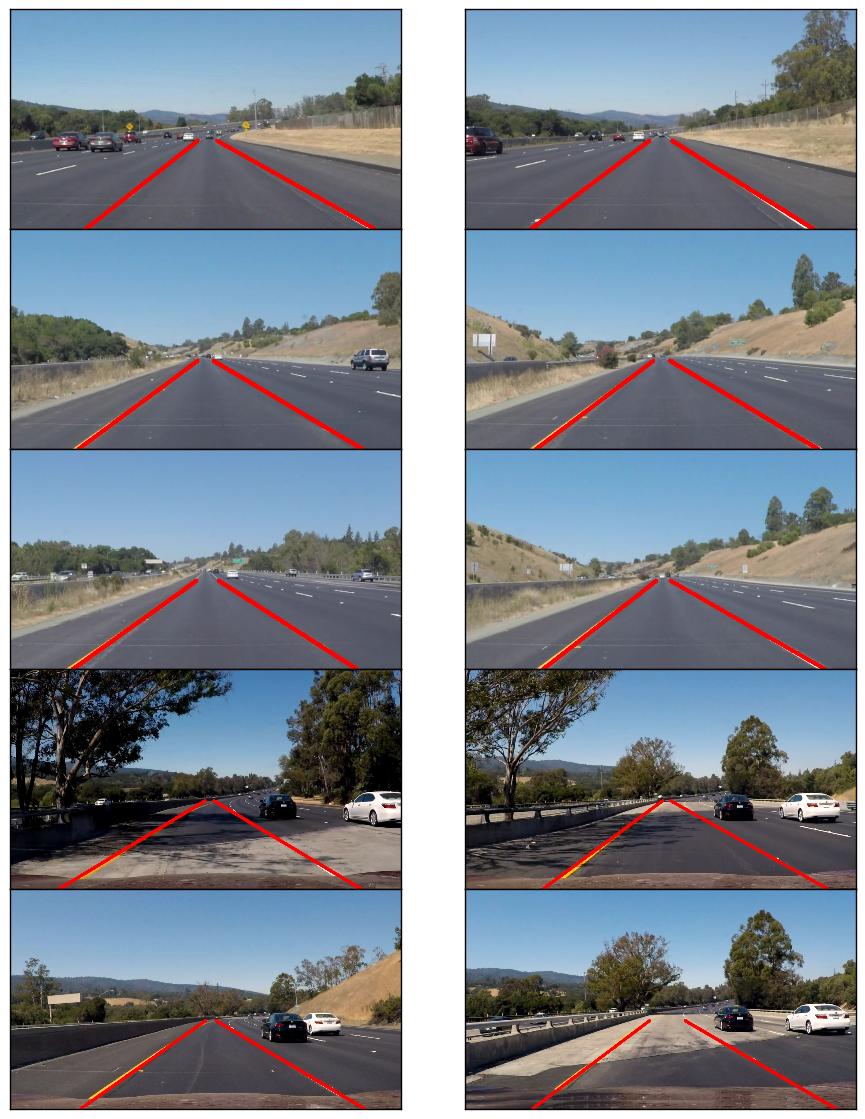

In [12]:
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lines(image, lane_lines(image, lines)))
    
show_images(lane_images)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

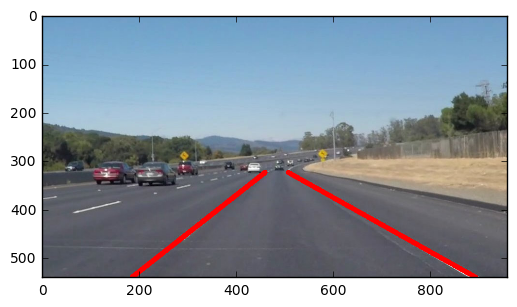

In [13]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    lane_image = pipeline(image)
    return lane_image

lane = process_image(test_images[0])
plt.imshow(lane)
plt.show()



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [15]:
white_output = 'test_videos_output/challenge_out.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_out.mp4
[MoviePy] Writing video test_videos_output/challenge_out.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:17<00:00, 14.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_out.mp4 

Wall time: 19.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft_out.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_out.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:21<00:00, 31.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_out.mp4 

Wall time: 22.8 s


In [18]:
HTML("""
<video width="480" height="270" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))